In [5]:
import os
import numpy as np
from tifffile import imread
from scipy.signal import correlate2d
from scipy.ndimage import shift
from scipy.stats import ttest_rel, wilcoxon
import matplotlib.pyplot as plt

# Define the directory paths
drs = ['/root/capsule/data/iGluSnFR-Registered-Sim-Data_8default/stripRegisteration_matlab/1/']

ngs_reg = np.full(len(drs), np.nan)
ngs_orig = np.full(len(drs), np.nan)

def mean_with_nan(data, axis):
    """Calculate the mean ignoring NaNs."""
    return np.nanmean(data, axis=axis)

def pad_to_match_size(target, reference):
    """Pad a smaller array to match the size of a larger array."""
    pad_x = (reference.shape[0] - target.shape[0]) // 2
    pad_y = (reference.shape[1] - target.shape[1]) // 2
    padded = np.pad(target, ((pad_x, reference.shape[0] - target.shape[0] - pad_x),
                             (pad_y, reference.shape[1] - target.shape[1] - pad_y)),
                    mode='constant', constant_values=np.nan)
    return padded

for idx, dr in enumerate(drs):
    print(f"Running file {idx + 1}")

    basename_start = dr.find('_scan_')
    basename = dr[basename_start:]
    print(basename)

    mov_reg_fn = os.path.join(dr, f"{basename}_REGISTERED_RAW.tif")
    mov_orig_fn = os.path.join(dr, f"{basename}.tif")

    mov_reg = imread(mov_reg_fn)
    mov_orig = imread(mov_orig_fn)

    meanIM_reg = mean_with_nan(mov_reg[:, :, 1::2], axis=2)
    meanIM_orig = mean_with_nan(mov_orig[:, 4:, 1::2], axis=2)

    fullFrame_orig = pad_to_match_size(meanIM_orig, meanIM_reg)

    # Cross-correlation to find shifts
    corr = correlate2d(fullFrame_orig, meanIM_reg, mode='same', boundary='fill', fillvalue=np.nan)
    max_corr_idx = np.unravel_index(np.nanargmax(corr), corr.shape)
    template_shifts = np.array(max_corr_idx) - np.array(corr.shape) // 2

    nanPix = np.isnan(meanIM_reg)
    meanIM_reg[nanPix] = 0

    # Shift the registered image
    meanIM_reg_shifted = shift(meanIM_reg, shift=-template_shifts[::-1], order=0)
    shifted_nanPix = shift(nanPix.astype(float), shift=-template_shifts[::-1], order=0).astype(bool)
    meanIM_reg_shifted[shifted_nanPix] = np.nan

    # Crop the shifted image to match the original frame's non-NaN region
    valid_rows = ~np.isnan(fullFrame_orig).all(axis=1)
    valid_cols = ~np.isnan(fullFrame_orig).all(axis=0)
    meanIM_reg_crop = meanIM_reg_shifted[np.ix_(valid_rows, valid_cols)]

    # Display fused images for comparison
    plt.figure()
    plt.imshow(np.hstack([
        meanIM_reg_crop / np.percentile(meanIM_reg_crop.flatten(), 99.5),
        meanIM_orig / np.percentile(meanIM_orig.flatten(), 99.5)
    ]), cmap='gray')
    plt.show()

    # Calculate gradient norms for crispness metric
    gx_orig, gy_orig = np.gradient(meanIM_orig)
    ngs_orig[idx] = np.linalg.norm(np.sqrt(gx_orig**2 + gy_orig**2), ord='fro')

    gx_reg, gy_reg = np.gradient(meanIM_reg_crop)
    ngs_reg[idx] = np.linalg.norm(np.sqrt(gx_reg**2 + gy_reg**2), ord='fro')

# Statistical tests
t_stat, p_ttest = ttest_rel(ngs_orig, ngs_reg, alternative='less')
_, p_signrank = wilcoxon(ngs_orig - ngs_reg, alternative='less')

# Determine significance level
if p_signrank < 0.001:
    sig_reg = '***'
elif p_signrank < 0.01:
    sig_reg = '**'
elif p_signrank < 0.05:
    sig_reg = '*'
else:
    sig_reg = 'n.s.'

# Plot results
plt.figure()
plt.plot([1]*len(ngs_orig), ngs_orig, 'o', color='gray')
plt.plot([2]*len(ngs_reg), ngs_reg, 'o', color='gray')
plt.errorbar([1, 2], [np.mean(ngs_orig), np.mean(ngs_reg)],
             yerr=[np.std(ngs_orig)/np.sqrt(len(drs)), np.std(ngs_reg)/np.sqrt(len(drs))],
             fmt='r.-', markersize=10, linewidth=1.5)

ylimits = plt.ylim()
max_point = max(np.max(ngs_orig), np.max(ngs_reg))
plt.plot([1, 2], [(ylimits[1] + max_point) / 2]*2, '-k', linewidth=2)
plt.text(1.5, (ylimits[1] + max_point) / 2, sig_reg,
         fontsize=16, ha='center', va='baseline')

plt.ylabel('Crispness Metric')
plt.xlim([0.5, 2.5])
plt.xticks([1, 2], ['Original', 'Strip Registration'])
plt.show()

Running file 1
/


FileNotFoundError: [Errno 2] No such file or directory: '/_REGISTERED_RAW.tif'

In [59]:
import os
import numpy as np
from tifffile import imread
import cv2
from scipy.signal import correlate2d
from scipy.ndimage import shift
from scipy.stats import ttest_rel, wilcoxon
import matplotlib.pyplot as plt

# Define the base paths for the directories
registered_data_path = '/root/capsule/data/iGluSnFR-Registered-Sim-Data_8default/stripRegisteration_matlab'
original_data_path = '/root/capsule/data/iGluSnFR_simulations_default'

# Number of folders (1 to 8)
folders = range(1, 9)

ngs_reg = np.full(len(folders), 0)
ngs_orig = np.full(len(folders), 0)

def mean_with_nan(data, axis):
    """Calculate the mean ignoring NaNs."""
    return np.nanmean(data, axis=axis)

def pad_to_match_size(target, reference):
    """Pad a smaller array to match the size of a larger array."""
    pad_x = (reference.shape[0] - target.shape[0]) // 2
    pad_y = (reference.shape[1] - target.shape[1]) // 2
    padded = np.pad(target, ((pad_x, reference.shape[0] - target.shape[0] - pad_x),
                             (pad_y, reference.shape[1] - target.shape[1] - pad_y)),
                    mode='constant', constant_values=np.nan)
    return padded

def matlab_round(x):
    """
    Replicates MATLAB's round function behavior

    In MATLAB:
    - round(4.5) = 5
    - round(-4.5) = -5
    """
    if x >= 0:
        return int(np.floor(x + 0.5))
    else:
        return int(np.ceil(x - 0.5))

def fast_xcorr2_nans(frame, template, shiftsCenter, dShift):
    dShift = round(dShift)  # Sanity check

    SE = np.ones((2 * dShift + 1, 2 * dShift + 1), dtype=np.uint8)

    # Valid pixels of the new frame
    rows, cols = template.shape
    M = np.float32([[1, 0, shiftsCenter[0]], [0, 1, shiftsCenter[1]]])
    tmp = cv2.warpAffine(
        1 - cv2.dilate(np.isnan(template).astype(np.uint8), SE, iterations=1),
        M,
        (cols, rows),
        borderMode=cv2.BORDER_CONSTANT,
        flags=cv2.INTER_NEAREST,
    ).astype(bool)
    fValid = np.zeros(frame.shape, dtype=bool)
    fValid[dShift:-dShift, dShift:-dShift] = (
        ~np.isnan(frame[dShift:-dShift, dShift:-dShift])
        & tmp[dShift:-dShift, dShift:-dShift]
    )

    tValid = np.roll(fValid, -shiftsCenter, axis=(0, 1)).astype(bool)

    F = frame[fValid]
    ssF = np.sqrt(F.dot(F))

    # Correlation is sum(A.*B)./(sqrt(ssA)*sqrt(ssB)); ssB is constant though
    tV0, tV1 = np.where(tValid)
    tValidInd = tV0 * cols + tV1

    shifts = np.arange(-dShift, dShift + 1)
    C = np.full((len(shifts), len(shifts)), np.nan)
    # Print datatypes before the loop
    for drix, shift_x in enumerate(shifts):
        for dcix, shift_y in enumerate(shifts):
            shifted_tValid = np.roll(tValid, (-shift_x, -shift_y), axis=(0, 1))
            T = template[shifted_tValid]
            ssT = np.sum(T**2)

            if ssT > 0:  # Only calculate if ssT is greater than zero
                C[drix, dcix] = np.sum(F * T) / np.sqrt(ssT)
            else:
                C[drix, dcix] = np.nan  # Handle cases where ssT is zero

    # plt.imshow(C)
    # Find maximum of correlation map
    maxval = np.nanmax(C)
    I = np.unravel_index(np.nanargmax(C), C.shape)
    rr, cc = I
    R = maxval / ssF  # Correlation coefficient

    if 0 < rr < len(shifts) - 1 and 0 < cc < len(shifts) - 1:
        # Perform superresolution upsampling
        ratioR = min(1e6, (C[rr, cc] - C[rr - 1, cc]) / (C[rr, cc] - C[rr + 1, cc]))
        dR = (1 - ratioR) / (1 + ratioR) / 2
        ratioC = min(1e6, (C[rr, cc] - C[rr, cc - 1]) / (C[rr, cc] - C[rr, cc + 1]))
        dC = (1 - ratioC) / (1 + ratioC) / 2
        motion = shiftsCenter + [shifts[rr] - dR, shifts[cc] - dC]
    else:
        # The optimum is at an edge of search range; no superresolution
        motion = shiftsCenter + [shifts[rr], shifts[cc]]

    if np.any(np.isnan(motion)):
        raise ValueError("Motion result contains NaN values")

    return motion, R

for idx in folders:
    print(f"Processing folder {idx}")

    # Construct file paths for registered and original data
    registered_file = os.path.join(registered_data_path, str(idx), "SIMULATION_scan_00001_1_Trial1_REGISTERED_RAW.tif")
    original_file = os.path.join(original_data_path, str(idx), "SIMULATION_scan_00001_1_Trial1.tif")

    # Read the TIFF files
    print('Read the TIFF files.......')
    mov_reg = np.transpose(imread(registered_file), (1, 2, 0))
    mov_orig = np.transpose(imread(original_file), (1, 2, 0))

    # Compute mean images ignoring NaNs
    print('Compute mean images ignoring NaNs......')
    meanIM_reg = mean_with_nan(mov_reg[:, :, 1::2], axis=2)
    meanIM_orig = mean_with_nan(mov_orig[:, :, 1::2], axis=2)

    # Pad original image to match the registered image size
    print('Pad original image to match the registered image size......')
    fullFrame_orig = pad_to_match_size(meanIM_orig, meanIM_reg)

    # Cross-correlation to find shifts
    print('Cross-correlation to find shifts.......')
    template_shifts, _ = fast_xcorr2_nans(fullFrame_orig, meanIM_reg, np.array([0,0]), 25)
    template_shifts = np.array([matlab_round(template_shifts[0]), matlab_round(template_shifts[1])])
    nanPix = np.isnan(meanIM_reg)
    meanIM_reg[nanPix] = 0

    # Shift the registered image
    print('Shift the registered image......')
    meanIM_reg_shifted = shift(meanIM_reg, shift=-template_shifts[::-1], order=0)
    shifted_nanPix = shift(nanPix.astype(float), shift=-template_shifts[::-1], order=0).astype(bool)
    meanIM_reg_shifted[shifted_nanPix] = np.nan

    # Crop the shifted image to match the original frame's non-NaN region
    valid_rows = ~np.isnan(fullFrame_orig).all(axis=1)
    valid_cols = ~np.isnan(fullFrame_orig).all(axis=0)
    meanIM_reg_crop = meanIM_reg_shifted[np.ix_(valid_rows, valid_cols)]

    # Display fused images for comparison
    plt.figure()
    plt.imshow(np.hstack([
        meanIM_reg_crop / np.percentile(meanIM_reg_crop.flatten(), 99.5),
        meanIM_orig / np.percentile(meanIM_orig.flatten(), 99.5)
    ]), cmap='gray')
    plt.show()

    # Calculate gradient norms for crispness metric
    print('Calculate gradient norms for crispness metric.....')
    gx_orig, gy_orig = np.gradient(meanIM_orig)
    ngs_orig[idx - 1] = np.linalg.norm(np.sqrt(gx_orig**2 + gy_orig**2), ord='fro')

    gx_reg, gy_reg = np.gradient(meanIM_reg_crop)
    ngs_reg[idx - 1] = np.linalg.norm(np.sqrt(gx_reg**2 + gy_reg**2), ord='fro')

# Statistical tests
t_stat, p_ttest = ttest_rel(ngs_orig, ngs_reg, alternative='less')
_, p_signrank = wilcoxon(ngs_orig - ngs_reg, alternative='less')

# Determine significance level
if p_signrank < 0.001:
    sig_reg = '***'
elif p_signrank < 0.01:
    sig_reg = '**'
elif p_signrank < 0.05:
    sig_reg = '*'
else:
    sig_reg = 'n.s.'

# Plot results
plt.figure()
plt.plot([1]*len(ngs_orig), ngs_orig, 'o', color='gray')
plt.plot([2]*len(ngs_reg), ngs_reg, 'o', color='gray')
plt.errorbar([1, 2], [np.mean(ngs_orig), np.mean(ngs_reg)],
             yerr=[np.std(ngs_orig)/np.sqrt(len(folders)), np.std(ngs_reg)/np.sqrt(len(folders))],
             fmt='r.-', markersize=10, linewidth=1.5)

ylimits = plt.ylim()
max_point = max(np.max(ngs_orig), np.max(ngs_reg))
plt.plot([1, 2], [(ylimits[1] + max_point) / 2]*2, '-k', linewidth=2)
plt.text(1.5, (ylimits[1] + max_point) / 2, sig_reg,
         fontsize=16, ha='center', va='baseline')

plt.ylabel('Crispness Metric')
plt.xlim([0.5, 2.5])
plt.xticks([1, 2], ['Original', 'Strip Registration'])
plt.show()


Processing folder 0
Read the TIFF files.......


FileNotFoundError: [Errno 2] No such file or directory: '/root/capsule/data/iGluSnFR-Registered-Sim-Data_8default/stripRegisteration_matlab/0/SIMULATION_scan_00001_1_Trial1_REGISTERED_RAW.tif'

Processing folder 1
Read the TIFF files.......


/tmp/ipykernel_19401/1794334737.py:142: RuntimeWarning: Mean of empty slice
  meanIM_reg = np.nanmean(mov_reg[:, :, 1::2], axis=2)


Compute mean images ignoring NaNs......
Pad original image to match the registered image size......
Cross-correlation to find shifts.......
template_shifts: [0.99371715 2.06111068]
Shift the registered image......


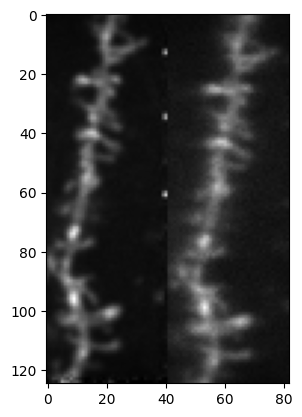

Processing folder 2
Skipping folder 2 because one of the folders does not exist.
Processing folder 3
Read the TIFF files.......
Compute mean images ignoring NaNs......
Pad original image to match the registered image size......
Cross-correlation to find shifts.......
template_shifts: [1.71468646 2.10435793]
Shift the registered image......


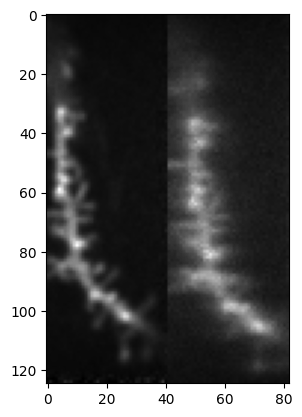

Processing folder 4
Read the TIFF files.......
Compute mean images ignoring NaNs......
Pad original image to match the registered image size......
Cross-correlation to find shifts.......
template_shifts: [ 8.3185505  -1.21772273]
Shift the registered image......


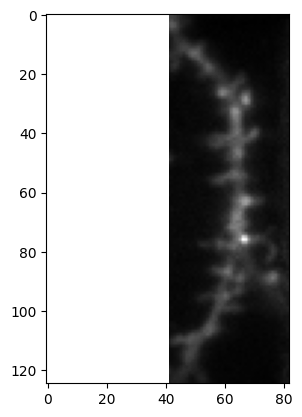

ValueError: cannot convert float NaN to integer

In [6]:
import os
import numpy as np
from tifffile import imread
import cv2
from scipy.signal import correlate2d
from scipy.ndimage import shift
from scipy.stats import ttest_rel, wilcoxon
import matplotlib.pyplot as plt

# Define the base paths for the directories
registered_data_path = '/root/capsule/data/iGluSnFR-Registered-Sim-Data_8default/stripRegisteration_matlab'
original_data_path = '/root/capsule/data/iGluSnFR_simulations_default'

# Number of folders (1 to 8)
folders = range(1, 8)

ngs_reg = np.full(len(folders), 0)
ngs_orig = np.full(len(folders), 0)

def fast_xcorr2_nans(frame, template, shiftsCenter, dShift):
    dShift = round(dShift)  # Sanity check

    SE = np.ones((2 * dShift + 1, 2 * dShift + 1), dtype=np.uint8)

    # Valid pixels of the new frame
    rows, cols = template.shape
    M = np.float32([[1, 0, shiftsCenter[0]], [0, 1, shiftsCenter[1]]])
    tmp = cv2.warpAffine(
        1 - cv2.dilate(np.isnan(template).astype(np.uint8), SE, iterations=1),
        M,
        (cols, rows),
        borderMode=cv2.BORDER_CONSTANT,
        flags=cv2.INTER_NEAREST,
    ).astype(bool)
    fValid = np.zeros(frame.shape, dtype=bool)
    fValid[dShift:-dShift, dShift:-dShift] = (
        ~np.isnan(frame[dShift:-dShift, dShift:-dShift])
        & tmp[dShift:-dShift, dShift:-dShift]
    )

    tValid = np.roll(fValid, -shiftsCenter, axis=(0, 1)).astype(bool)

    F = frame[fValid]
    ssF = np.sqrt(F.dot(F))

    # Correlation is sum(A.*B)./(sqrt(ssA)*sqrt(ssB)); ssB is constant though
    tV0, tV1 = np.where(tValid)
    tValidInd = tV0 * cols + tV1

    shifts = np.arange(-dShift, dShift + 1)
    C = np.full((len(shifts), len(shifts)), np.nan)
    # Print datatypes before the loop
    for drix, shift_x in enumerate(shifts):
        for dcix, shift_y in enumerate(shifts):
            shifted_tValid = np.roll(tValid, (-shift_x, -shift_y), axis=(0, 1))
            T = template[shifted_tValid]
            ssT = np.sum(T**2)

            if ssT > 0:  # Only calculate if ssT is greater than zero
                C[drix, dcix] = np.sum(F * T) / np.sqrt(ssT)
            else:
                C[drix, dcix] = np.nan  # Handle cases where ssT is zero

    # plt.imshow(C)
    # Find maximum of correlation map
    maxval = np.nanmax(C)
    I = np.unravel_index(np.nanargmax(C), C.shape)
    rr, cc = I
    R = maxval / ssF  # Correlation coefficient

    if 0 < rr < len(shifts) - 1 and 0 < cc < len(shifts) - 1:
        # Perform superresolution upsampling
        ratioR = min(1e6, (C[rr, cc] - C[rr - 1, cc]) / (C[rr, cc] - C[rr + 1, cc]))
        dR = (1 - ratioR) / (1 + ratioR) / 2
        ratioC = min(1e6, (C[rr, cc] - C[rr, cc - 1]) / (C[rr, cc] - C[rr, cc + 1]))
        dC = (1 - ratioC) / (1 + ratioC) / 2
        motion = shiftsCenter + [shifts[rr] - dR, shifts[cc] - dC]
    else:
        # The optimum is at an edge of search range; no superresolution
        motion = shiftsCenter + [shifts[rr], shifts[cc]]

    if np.any(np.isnan(motion)):
        raise ValueError("Motion result contains NaN values")

    return motion, R
    
def find_tiff_file(folder_path):
    """Find the first .tif file in a folder."""
    if not os.path.exists(folder_path):
        return None  # Return None if the folder does not exist
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.tif'):
            return os.path.join(folder_path, file_name)
    return None  # Return None if no .tif file is found

def mean_with_nan(data, axis):
    """Calculate the mean ignoring NaNs."""
    return np.nanmean(data, axis=axis)

def pad_to_match_size(target, reference):
    """Pad a smaller array to match the size of a larger array."""
    pad_x = (reference.shape[0] - target.shape[0]) // 2
    pad_y = (reference.shape[1] - target.shape[1]) // 2
    padded = np.pad(target, ((pad_x, reference.shape[0] - target.shape[0] - pad_x),
                             (pad_y, reference.shape[1] - target.shape[1] - pad_y)),
                    mode='constant', constant_values=np.nan)
    return padded

def matlab_round(x):
    """Replicates MATLAB's round function behavior."""
    if x >= 0:
        return int(np.floor(x + 0.5))
    else:
        return int(np.ceil(x - 0.5))

for idx in folders:
    print(f"Processing folder {idx}")

    # Construct folder paths for registered and original data
    registered_folder = os.path.join(registered_data_path, str(idx))
    original_folder = os.path.join(original_data_path, str(idx))

    # Check if both folders exist
    if not os.path.exists(registered_folder) or not os.path.exists(original_folder):
        print(f"Skipping folder {idx} because one of the folders does not exist.")
        continue

    # Dynamically find the TIFF files in each folder
    registered_file = find_tiff_file(registered_folder)
    original_file = find_tiff_file(original_folder)

    # Skip processing if either file is missing
    if not registered_file or not original_file:
        print(f"Skipping folder {idx} due to missing TIFF files.")
        continue

    # Read the TIFF files
    print('Read the TIFF files.......')
    mov_reg = np.transpose(imread(registered_file), (2, 1, 0))
    mov_orig = np.transpose(imread(original_file), (2, 1, 0))

    meanIM_reg = np.nanmean(mov_reg[:, :, 1::2], axis=2)
    meanIM_orig = np.nanmean(mov_orig[:, 4:, 1::2], axis=2)
    
    # Compute mean images ignoring NaNs
    print('Compute mean images ignoring NaNs......')
    pad_width = [(int(np.floor((meanIM_reg.shape[i] - meanIM_orig.shape[i]) / 2)), 
                int(np.ceil((meanIM_reg.shape[i] - meanIM_orig.shape[i]) / 2))) for i in range(2)]
    fullFrame_orig = np.pad(meanIM_orig, pad_width, mode='constant', constant_values=np.nan)

    pad_width_pre = [(meanIM_reg.shape[i] - fullFrame_orig.shape[i], 0) for i in range(2)]
    fullFrame_orig = np.pad(fullFrame_orig, pad_width_pre, mode='constant', constant_values=np.nan)

    # Pad original image to match the registered image size
    print('Pad original image to match the registered image size......')
    fullFrame_orig = pad_to_match_size(meanIM_orig, meanIM_reg)

    # Cross-correlation to find shifts
    print('Cross-correlation to find shifts.......')
    template_shifts, _ = fast_xcorr2_nans(fullFrame_orig, meanIM_reg, np.array([0,0]), 25)
    print('template_shifts:', template_shifts)
    template_shifts = np.array([matlab_round(template_shifts[0]), matlab_round(template_shifts[1])])
    
    nanPix = np.isnan(meanIM_reg)
    meanIM_reg[nanPix] = 0

    # Shift the registered image
    print('Shift the registered image......')
    meanIM_reg_shifted = shift(meanIM_reg, shift=-template_shifts[::-1], order=0)
    shifted_nanPix = shift(nanPix.astype(float), shift=-template_shifts[::-1], order=0).astype(bool)
    meanIM_reg_shifted[shifted_nanPix] = np.nan

    # Crop the shifted image to match the original frame's non-NaN region
    valid_rows = ~np.isnan(fullFrame_orig).all(axis=1)
    valid_cols = ~np.isnan(fullFrame_orig).all(axis=0)
    
    meanIM_reg_crop = meanIM_reg_shifted[np.ix_(valid_rows, valid_cols)]

    # Display fused images for comparison
    plt.figure()
    plt.imshow(np.hstack([
        meanIM_reg_crop / np.percentile(meanIM_reg_crop.flatten(), 99.5),
        meanIM_orig / np.percentile(meanIM_orig.flatten(), 99.5)
    ]), cmap='gray')
    
    plt.show()

    # Calculate gradients and Frobenius norms for both images
    gx, gy = np.gradient(meanIM_orig)
    ngs_orig[idx - 1] = np.linalg.norm(np.sqrt(gx**2 + gy**2), 'fro')

    gx, gy = np.gradient(meanIM_reg_crop)
    ngs_reg[idx - 1] = np.linalg.norm(np.sqrt(gx**2 + gy**2), 'fro')

# Statistical tests and plotting results remain unchanged.
    


In [7]:
ngs_orig, ngs_reg

(array([658,   0, 478, 673,   0,   0,   0]),
 array([1105,    0,  975,    0,    0,    0,    0]))

In [4]:
from scipy import stats

H, P = stats.ttest_ind(ngs_orig, ngs_reg, alternative='less')

In [2]:
from scipy import stats

# Perform independent t-test
H, P = stats.ttest_ind(ngs_orig, ngs_reg, alternative='less')
CI = stats.t.interval(0.95, len(ngs_orig)-1, loc=np.mean(ngs_orig)-np.mean(ngs_reg), scale=np.sqrt(stats.sem(ngs_orig)**2 + stats.sem(ngs_reg)**2))
STATS = {'tstat': H, 'pvalue': P}

# Perform Wilcoxon signed-rank test
P, H = stats.wilcoxon(ngs_orig, ngs_reg, alternative='less')
STATS = {'statistic': H, 'pvalue': P}

print("T-test results:", H, P, CI, STATS)
print("Wilcoxon signed-rank test results:", P, H, STATS)

# Determine significance level
if p_signrank < 0.001:
    sig_reg = '***'
elif p_signrank < 0.01:
    sig_reg = '**'
elif p_signrank < 0.05:
    sig_reg = '*'
else:
    sig_reg = 'n.s.'

# Plot results
plt.figure()
plt.plot([1]*len(ngs_orig), ngs_orig, 'o', color='gray')
plt.plot([2]*len(ngs_reg), ngs_reg, 'o', color='gray')
plt.errorbar([1, 2], [np.mean(ngs_orig), np.mean(ngs_reg)],
             yerr=[np.std(ngs_orig)/np.sqrt(len(folders)), np.std(ngs_reg)/np.sqrt(len(folders))],
             fmt='r.-', markersize=10, linewidth=1.5)

ylimits = plt.ylim()
max_point = max(np.max(ngs_orig), np.max(ngs_reg))
plt.plot([1, 2], [(ylimits[1] + max_point) / 2]*2, '-k', linewidth=2)
plt.text(1.5, (ylimits[1] + max_point) / 2, sig_reg,
         fontsize=16, ha='center', va='baseline')

plt.ylabel('Crispness Metric')
plt.xlim([0.5, 2.5])
plt.xticks([1, 2], ['Original', 'Strip Registration'])
plt.show()


/opt/conda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:6558: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


TypeError: object of type 'numpy.float32' has no len()